## Siamese LSTM using GloVe 300d

In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2018-12-05 08:13:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-12-05 08:13:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.25MB/s    in 2m 47s  

2018-12-05 08:16:27 (4.92 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
import pandas as pd
import numpy as np
from keras.layers.embeddings import Embedding
from keras.layers import Dropout, BatchNormalization, Input, Embedding, Flatten, concatenate, Dense, LSTM, subtract, multiply, Bidirectional
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [0]:
np.random.seed(42)

In [0]:
df_train = pd.read_csv('train_data.csv')
df_labels = pd.read_csv('train_labels.csv')

In [0]:
df_train = df_train.astype({'question1': str, 'question2': str})

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323144 entries, 0 to 323143
Data columns (total 3 columns):
id           323144 non-null int64
question1    323144 non-null object
question2    323144 non-null object
dtypes: int64(1), object(2)
memory usage: 7.4+ MB


In [0]:
# Create the questions vocabulary
tokenizer = Tokenizer()
questions = pd.concat([df_train['question1'], df_train['question2']])
tokenizer.fit_on_texts(questions)

In [0]:
# We add one, because we will need to specify the integer for the largest encoded word as an array index, 
# e.g. words encoded 1 to 21 with array indices 0 to 21 or 22 positions.

vocab_size = len(tokenizer.word_index) + 1

In [0]:
# Integer Encode
q1_int_sequence = tokenizer.texts_to_sequences(df_train['question1'])
q2_int_sequence = tokenizer.texts_to_sequences(df_train['question2'])

In [0]:
q1_padded = pad_sequences(q1_int_sequence, maxlen=25)
q2_padded = pad_sequences(q2_int_sequence, maxlen=25)

In [0]:
# Load the Glove Embeddings
f = open('glove.6B.300d.txt')
# f = open('glove.6B.100d.txt')
embeddings_index = dict()
for line in f:
    embedding = line.split()
    word_key = embedding[0]
    word_weights = np.asarray(embedding[1:], dtype='float32')
    embeddings_index[word_key] = word_weights
f.close()

In [0]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding = embeddings_index.get(word)
    if embedding is not None:
        embedding_matrix[i] = embedding

In [0]:
# Create the network
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=25, trainable=False)
lstm_layer = Bidirectional(LSTM(256, activation='tanh'))

q1_input = Input(shape=(25,))
q1_model = embedding_layer(q1_input)
q1_model = lstm_layer(q1_model)

q2_input = Input(shape=(25,))
q2_model = embedding_layer(q2_input)
q2_model = lstm_layer(q2_model)

In [0]:
# Features Layer
# Load Features
features = pd.read_csv('feats.csv')
# Create Features Layer
features_layer = Input(shape=(features.shape[1],), dtype='float32')
features_dense = Dense(100, activation='relu')(features_layer)

In [0]:
DENSE_OUTPUT = 200
merged_subtract = subtract([q1_model, q2_model])
merged_multiply = multiply([q1_model, q2_model])
merged_model = concatenate([q1_model, q2_model, merged_subtract, merged_multiply, features_dense])
merged_model = Dropout(0.1)(merged_model)
merged_model = BatchNormalization()(merged_model)
merged_model = Dense(DENSE_OUTPUT, activation='relu')(merged_model)
merged_model = Dropout(0.1)(merged_model)
merged_model = BatchNormalization()(merged_model)
merged_model = Dense(DENSE_OUTPUT, activation='relu')(merged_model)

merged_model = Dropout(0.1)(merged_model)
merged_model = BatchNormalization()(merged_model)
merged_model = Dense(1, activation='sigmoid')(merged_model)

In [0]:
model = Model(inputs=[q1_input,q2_input, features_layer], outputs=merged_model)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train-Validation Split

In [0]:
# Word Sequences
X = np.stack((q1_padded, q2_padded), axis=1)
y = df_labels['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

# Features
feat_train, feat_test, y_train, y_test = train_test_split(features, y, test_size=0.1, random_state=42)

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 300)      23224200    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 512)          1140736     embedding_2[0][0]                
          

In [53]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True), 
             ModelCheckpoint('bilstm_features_1024.h5', monitor='val_acc', save_best_only=True)]

history = model.fit([Q1_train, Q2_train, feat_train], y_train, epochs=25, batch_size=1024, callbacks=callbacks,
                   validation_data=([Q1_test, Q2_test, feat_test], y_test))

Train on 290829 samples, validate on 32315 samples
Epoch 1/25
290829/290829 [==============================] - 143s 490us/step - loss: 0.3425 - acc: 0.8463 - val_loss: 0.4350 - val_acc: 0.8155
Epoch 2/25
290829/290829 [==============================] - 139s 477us/step - loss: 0.2762 - acc: 0.8792 - val_loss: 0.3804 - val_acc: 0.8320
Epoch 3/25
290829/290829 [==============================] - 139s 477us/step - loss: 0.2419 - acc: 0.8971 - val_loss: 0.4173 - val_acc: 0.8293
Epoch 4/25
290829/290829 [==============================] - 138s 476us/step - loss: 0.2213 - acc: 0.9062 - val_loss: 0.4014 - val_acc: 0.8360
Epoch 5/25
290829/290829 [==============================] - 138s 476us/step - loss: 0.1977 - acc: 0.9174 - val_loss: 0.4101 - val_acc: 0.8403
Epoch 6/25
290829/290829 [==============================] - 139s 477us/step - loss: 0.1815 - acc: 0.9242 - val_loss: 0.4402 - val_acc: 0.8390
Epoch 7/25
290829/290829 [==============================] - 138s 476us/step - loss: 0.1817 - acc:

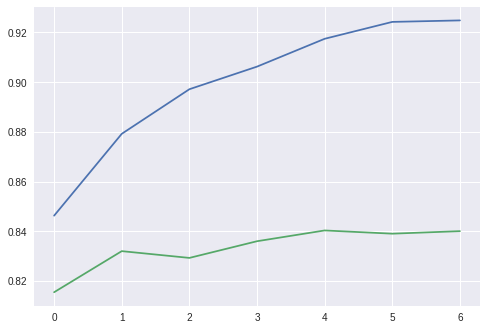

In [54]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [0]:
history.history.keys()

dict_keys(['loss', 'acc'])

In [0]:
# Apply on test set

In [0]:
df_test = pd.read_csv('test_data.csv')

In [0]:
test_q1_seq = tokenizer.texts_to_sequences(df_test['question1'])
test_q2_seq = tokenizer.texts_to_sequences(df_test['question2'])

In [0]:
test_q1_padded = pad_sequences(test_q1_seq, maxlen=25)
test_q2_padded = pad_sequences(test_q2_seq, maxlen=25)

In [0]:
test_features = pd.read_csv('test_feats.csv')

In [0]:
test_features.head()

In [0]:
predicted = model.predict([test_q1_padded, test_q2_padded, test_features])

In [0]:
submission = pd.DataFrame()
submission['test_id'] = df_test['test_id']
submission['is_duplicate'] = predicted

In [0]:
submission.loc[submission.is_duplicate < 0.5, 'is_duplicate'] = 0                                                                                                                                                             
submission.loc[submission.is_duplicate >= 0.5, 'is_duplicate'] = 1
submission['is_duplicate'] = submission['is_duplicate'].astype(int)

In [0]:
submission.head()

In [0]:
submission.to_csv('bilstm_dbd_dbd_dbd_256.csv', index=False)

In [57]:
model.evaluate([Q1_test, Q2_test, feat_test], y_test)

32315/32315 [==============================] - 121s 4ms/step


[0.3804284576364075, 0.8319975243805547]

In [0]:
model.save('bilstm_dbd_dbd_dbd_256.h5')

In [0]:
model = model.load_weights('bilstm_simple_1024.h5')

OSError: ignored

(81126, 1)